# EEG data and indexing

We follow the tutorial [EEG data and indexing in Matlab](http://mikexcohen.com/lecturelets/indexing/indexing.html).

First we import the libraries we'll need later on

In [1]:
import numpy as np
import scipy.io
import mne
import matplotlib.pyplot as plt

from utils import pol2cart

Use `scipy.io.loadmat` to load the sample data. `struct_as_record=False` reads the file into a structure that I found easier to use. The `EEG` object contains all our data and metadata.

In [2]:
EEGcontents = scipy.io.loadmat('../data/sampleEEGdata.mat', struct_as_record=False)
EEG = EEGcontents['EEG'].item()

Extract a few arrays for later use. Here, `np.squeeze()` is used to remove any superfluous dimensions (e.g. go from an array of shape `(1, 5, 3)` to an array of shape `(5, 3)`), and `.item()` is used on arrays with a single item, to extract that item (it raises an error if the arry is empty or has more than one item).

In [3]:
# The array of timestamps, in milliseconds, with time 0 being stimulus onset
times = np.squeeze(EEG.times)
# The (y, x) locations of electrodes on a topographical map of the head
chanlocsYX = np.array([pol2cart(loc.radius.item(),
                                loc.theta.item() * np.pi / 180)
                       for loc in EEG.chanlocs.flat])[:, ::-1]
# The labels of the electrodes (same length as `chanlocs`)
chanlabels = np.array([loc.labels.item() for loc in EEG.chanlocs.flat])

## Helpers

Now we define two helpers that we use later on:
- `closest_idx()`: when you have an array of values called `array`, and a value `x`, and you want to find the index `i` for which `array[i]` is closest to `x`
- `istring_idx()`: when you have an array of strings (e.g. labels), and want to find the index of a certain string in that array (without caring about case)

In [4]:
def closest_idx(array, value):
    """Find the index at which `array` is closest to `value`;
    if `array` is multidimensional, return a tuple."""
    amin_flat = np.argmin(np.abs(array - value))
    if len(array.shape) > 1:
        return np.unravel_index(amin_flat, array.shape)
    else:
        return amin_flat

def istring_idx(str_array, string):
    """Find the index of `string` in `str_array` (the match is case-insensitive);
    raise an error if no match is found or if several matches are found."""
    match_idx = np.where(np.char.lower(str_array) == string.lower())
    if len(match_idx[0]) == 0:
        raise ValueError("String '{}' not found".format(string))
    elif len(match_idx[0]) > 1:
        raise ValueError("String '{}' found several times".format(string))
    if len(str_array.shape) > 1:
        return tuple(idx[0] for idx in match_idx)
    else:
        return match_idx[0][0]

## Topoplot

The first exercise in the video: make a topographical plot of the average activity of all trials, at time 300ms.

`EEG.data` has shape `channels x timesteps x trials`

In [5]:
time2plot = 300                          # in milliseconds
id2plot = closest_idx(times, time2plot)  # index of the value in `times` which is closest to `time2plot`
data2plot = EEG.data[:, id2plot, :].mean(axis=-1)  # average over trials

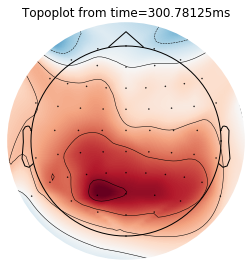

In [6]:
fig, ax = plt.subplots()
ax.set_title('Topoplot from time={}ms'.format(times[id2plot]))
mne.viz.plot_topomap(data=data2plot, pos=chanlocsYX, axes=ax, outlines='skirt');

## ERP for one electrode

The second example in the video: plot the Event-Related Potential for a single electrode, averaged over trials.

In [7]:
electrode_name = 'p1'
electrode_idx = istring_idx(chanlabels, electrode_name)  # index of `electrode_name` in `chanlabels`

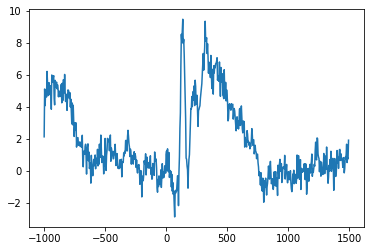

In [8]:
plt.plot(times, EEG.data[electrode_idx, :, :].mean(-1))  # average over trials

## ERP for several electrodes

The third example in the video: plot the Event-Related Potential for several electrodes, averaged over trials.

In [9]:
electrode_names = ['p1', 'fc6', 't8']
electrode_indices = [istring_idx(chanlabels, name) for name in electrode_names]

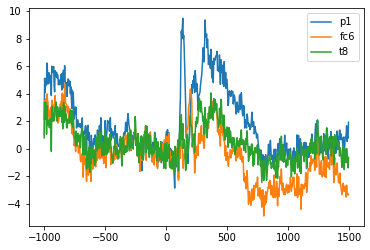

In [10]:
plt.plot(times, EEG.data[electrode_indices, :, :].mean(-1).T)  # average over trials, transpose for matplotlib
plt.legend(electrode_names)